# Random Forest in Scikit-Learn

In this notebook we will use the History of Baseball dataset to demonstrate model interpretation with Random Forest (http://www.seanlahman.com/baseball-archive/statistics/)

In [1]:
# load in necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from preprocessing import teams_preprocess

plt.style.use('ggplot')

In [2]:
# load in data and preprocess

teams_df = pd.read_csv('data/Teams.csv')

teams = teams_preprocess(teams_df)

teams.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964 entries, 1813 to 2804
Data columns (total 54 columns):
yearid            964 non-null int64
lgid              964 non-null object
teamid            964 non-null object
franchid          964 non-null object
divid             964 non-null object
rank              964 non-null int64
g                 964 non-null int64
ghome             964 non-null float64
w                 964 non-null float64
l                 964 non-null float64
divwin            964 non-null object
wcwin             624 non-null object
lgwin             964 non-null object
wswin             964 non-null object
r                 964 non-null float64
ab                964 non-null float64
h                 964 non-null float64
2b                964 non-null float64
3b                964 non-null float64
hr                964 non-null float64
bb                964 non-null float64
so                964 non-null float64
sb                964 non-null float64
cs      

In [3]:
# narrow down columns to consider for Random Forest model
cols_for_regression = ['doubles', 'triples', 'hr', 'bb','so','sb', 'cg', 'ba',
                        'ha', 'bba', 'soa', 'e', 'era', 'obp','sp','ops', 'w']

# reformat some columns
teams = teams.rename(index=str, columns={'1b':'singles', '2b':'doubles', '3b':'triples'})

rteams = teams[cols_for_regression]

print(rteams.columns)

Index(['doubles', 'triples', 'hr', 'bb', 'so', 'sb', 'cg', 'ba', 'ha', 'bba',
       'soa', 'e', 'era', 'obp', 'sp', 'ops', 'w'],
      dtype='object')


In [4]:
y = rteams.pop('w').values

cols = rteams.columns.tolist()
X = rteams.values

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Feature Importances

In [5]:
rf = RandomForestRegressor(n_estimators=50)
rf.fit(X_train, y_train)

scores = rf.feature_importances_

fi = zip(cols, scores)

for feat in fi:
    print(feat)

('doubles', 0.010062026800895156)
('triples', 0.010054862753190104)
('hr', 0.014203072824826453)
('bb', 0.013678190297279492)
('so', 0.008376186803336386)
('sb', 0.010448741074523543)
('cg', 0.0083826959360138176)
('ba', 0.012338963376321893)
('ha', 0.021289501429212883)
('bba', 0.013910446150675352)
('soa', 0.01055481948492973)
('e', 0.015111752982840159)
('era', 0.39351856542864583)
('obp', 0.098342561519804791)
('sp', 0.039596200416978033)
('ops', 0.32013141272052648)


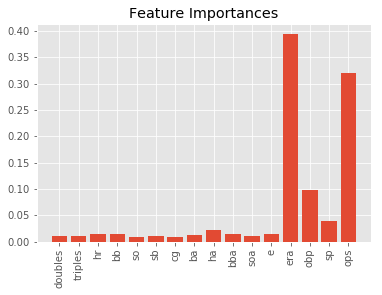

In [6]:
plt.bar(range(len(cols)), scores, );
plt.xticks(range(len(cols)), cols, rotation='vertical');
plt.title('Feature Importances');

## Leave One Out 

In [7]:
def leave_one_out(df):
    y = df.pop('w')
    X = df
    base_mod = RandomForestRegressor(n_estimators=50, oob_score=True).fit(X, y)
    base_score = base_mod.oob_score_
    cols = df.columns.tolist()
    diff_from_base = []
    for col in cols:
        X = df
        X = X.loc[:,[c for c in cols if c != col]]
        rf = RandomForestRegressor(n_estimators=50, oob_score=True).fit(X, y)
        diff_from_base.append(abs(base_score - rf.oob_score_))
    return cols, diff_from_base



In [8]:
columns, loo_score = leave_one_out(teams[cols_for_regression])

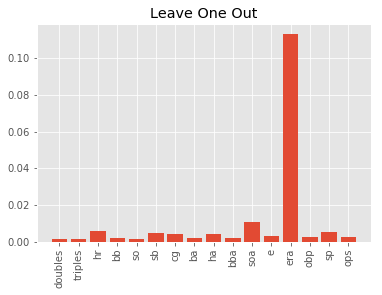

In [9]:
plt.bar(range(len(columns)), loo_score);
plt.xticks(range(len(columns)), columns, rotation='vertical');
plt.title('Leave One Out');

***Why is ERA so much more important here?***  One explanation is that most of the metrics we are looking at are offensive.  Therefore, there is quite a bit of information overlap on the offensive side of things.  Taking an offensive metric out will not have nearly as large of an impact as taking out ERA, since that information isn't captured in other metrics...

## Identify "Multicolinearity"
Here we aren't concerned about "colinearity" affecting our model, just the interpretation of it.  If two features contain very similar information, their feature importances will be negatively impacted.  Below, we will iteratively drop out columns and see how feature importances change.

This allows us to get a better understanding for the importance each of our features adds to the model.  ***It is also possible to drop out more than one feature at a time.  In fact, we may need to if 3 or more features are highly corrlated.***  



In [10]:
def leave_one_out_fi(df):
    y = df.pop('w')
    X = df
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    cols = df.columns.tolist()
    for col in cols:
        cols_to_plot = [c for c in cols if c != col]
        feats = X_train.loc[:, cols_to_plot]
        rf = RandomForestRegressor(n_estimators=50).fit(feats, y_train)
        scores = rf.feature_importances_
        plt.bar(range(len(cols) - 1), scores)
        plt.xticks(range(len(cols) - 1), cols_to_plot, rotation='vertical')
        plt.subplots_adjust(bottom=0.25)
        plt.savefig('images/left_out_{}.png'.format(col))
        plt.close('all')
        

In [11]:
leave_one_out_fi(teams[cols_for_regression])

# GridSearchCV 101

GridSearchCV allows us get cross validated scores on different combinations of metrics.

In [22]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

params = {'n_estimators': [10, 50, 100], 'max_leaf_nodes': [5, 10, 15]}  # can pass any feature in here...

gs = GridSearchCV(rf, params, scoring='neg_mean_squared_error')

gs.fit(X_train, y_train)

print('Best Hyperparmeters', gs.best_estimator_, '\n', 'MSE:', -1* gs.best_score_)

Best Hyperparmeters RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=15,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False) 
 MSE: 0.0010775738452
